In [145]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import time


# Task 2
## Part 1

### Load Data

In [129]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

In [130]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return images.astype('float32')

In [131]:
train_images = preprocess_images(train_images)
test_images  = preprocess_images(test_images)

In [132]:
train_size = train_images.shape[0]
batch_size = 64
test_size = test_images.shape[0]

In [133]:
train_set = (tf.data.Dataset.from_tensor_slices(train_images)).shuffle(train_size).batch(batch_size)
test_set = (tf.data.Dataset.from_tensor_slices(test_images)).shuffle(test_size).batch(batch_size)

In [135]:
class VAE(keras.Model):
    
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = keras.Sequential( [
            keras.layers.InputLayer(input_shape=(28,28,1)),
            keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu'),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu'),
            keras.layers.Flatten(),
            
            keras.layers.Dense(latent_dim * 2)
            ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [136]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [137]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
    x = tf.cast(x, tf.float32)
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [138]:
epochs = 25
latent_dim =2
gen_num = 16

In [139]:
rand_vector = tf.random.normal( shape=[gen_num, latent_dim])
model = VAE(latent_dim)

In [140]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


In [141]:
assert batch_size >= gen_num
for test_batch in test_set.take(1):
    test_sample = test_batch[0:gen_num, :, :, :]

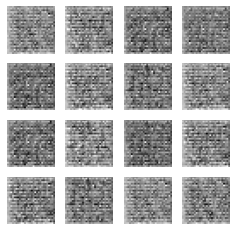

Epoch: 1, Test set ELBO: -308.97344970703125, time elapse for current epoch: 40.005263566970825


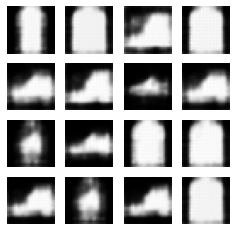

Epoch: 2, Test set ELBO: -289.3319091796875, time elapse for current epoch: 40.51636099815369


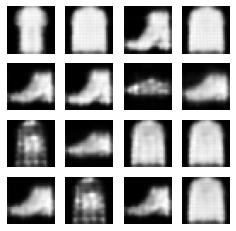

Epoch: 3, Test set ELBO: -282.25030517578125, time elapse for current epoch: 38.96782732009888


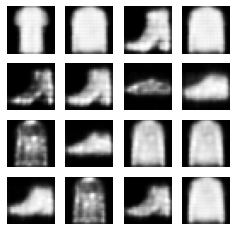

Epoch: 4, Test set ELBO: -278.751953125, time elapse for current epoch: 38.79200291633606


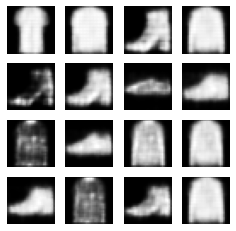

Epoch: 5, Test set ELBO: -276.9982604980469, time elapse for current epoch: 40.014917612075806


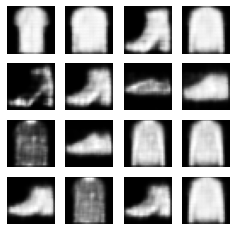

Epoch: 6, Test set ELBO: -275.7192077636719, time elapse for current epoch: 82.61282157897949


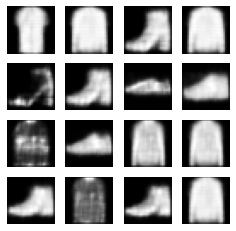

Epoch: 7, Test set ELBO: -274.6827087402344, time elapse for current epoch: 37.54123091697693


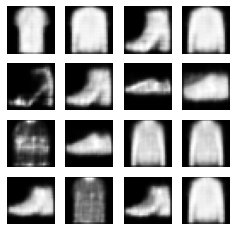

Epoch: 8, Test set ELBO: -273.8678283691406, time elapse for current epoch: 38.15796709060669


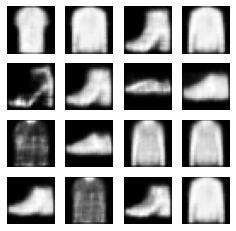

Epoch: 9, Test set ELBO: -272.9655456542969, time elapse for current epoch: 37.7600634098053


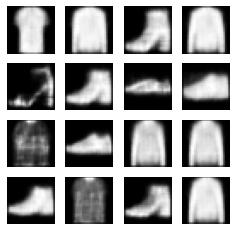

Epoch: 10, Test set ELBO: -272.64300537109375, time elapse for current epoch: 79.98846817016602


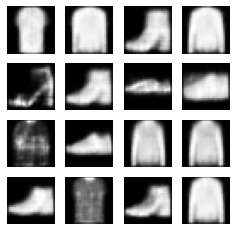

Epoch: 11, Test set ELBO: -271.9003601074219, time elapse for current epoch: 40.63377618789673


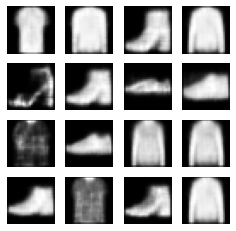

Epoch: 12, Test set ELBO: -271.87158203125, time elapse for current epoch: 38.59788107872009


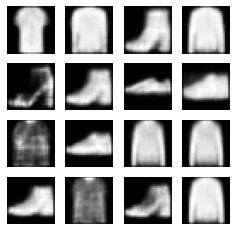

Epoch: 13, Test set ELBO: -271.2079772949219, time elapse for current epoch: 86.08726072311401


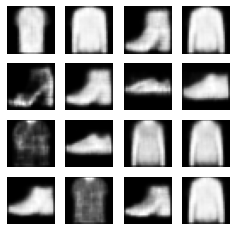

Epoch: 14, Test set ELBO: -270.8365478515625, time elapse for current epoch: 42.24386477470398


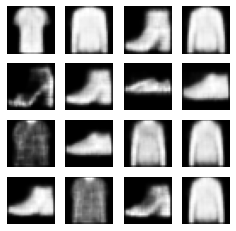

Epoch: 15, Test set ELBO: -270.6244812011719, time elapse for current epoch: 43.53953576087952


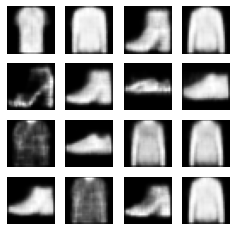

Epoch: 16, Test set ELBO: -270.2457580566406, time elapse for current epoch: 38.359118938446045


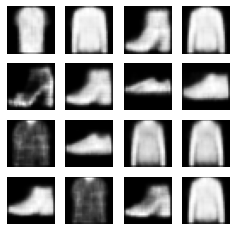

Epoch: 17, Test set ELBO: -270.040771484375, time elapse for current epoch: 107.50286316871643


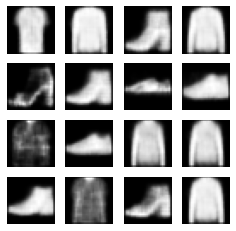

Epoch: 18, Test set ELBO: -269.76971435546875, time elapse for current epoch: 38.78248405456543


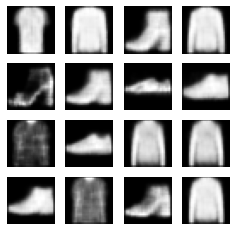

Epoch: 19, Test set ELBO: -269.64385986328125, time elapse for current epoch: 43.4231162071228


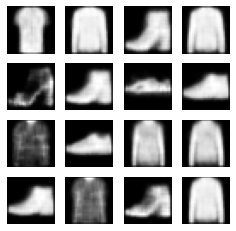

Epoch: 20, Test set ELBO: -269.2707824707031, time elapse for current epoch: 84.13259148597717


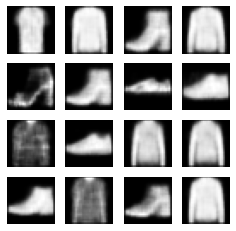

Epoch: 21, Test set ELBO: -269.0582580566406, time elapse for current epoch: 40.75107669830322


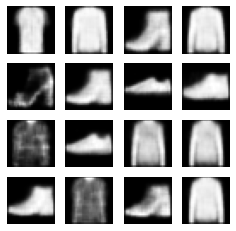

Epoch: 22, Test set ELBO: -269.0492248535156, time elapse for current epoch: 64.5492012500763


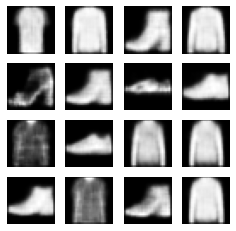

Epoch: 23, Test set ELBO: -268.68218994140625, time elapse for current epoch: 37.11109781265259


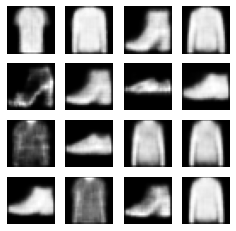

Epoch: 24, Test set ELBO: -268.5916442871094, time elapse for current epoch: 41.98507213592529


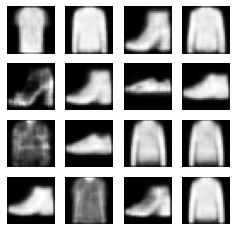

Epoch: 25, Test set ELBO: -268.47271728515625, time elapse for current epoch: 83.41321969032288


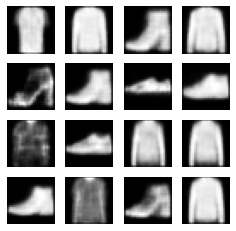

In [142]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_set:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = keras.metrics.Mean()
    for test_x in test_set:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)


### Part 2

In [143]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

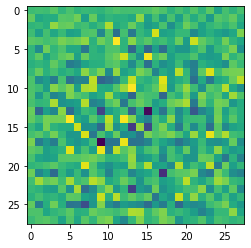

In [211]:
GAN = make_generator_model()

noise = tf.random.normal([1,100])
gan_image = GAN(noise, training=False)

plt.imshow(gan_image[0])

In [178]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [212]:
discriminator = make_discriminator_model()
discriminator(gan_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00205399]], dtype=float32)>

In [213]:
loss = keras.losses.BinaryCrossentropy(from_logits=True)

In [188]:
def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    total_loss = real_loss + fake_loss
    return total_loss

In [214]:
gan_optimizer = keras.optimizers.Adam(.0001)
discriminator_optimizer = keras.optimizers.Adam(.0001)

In [215]:
EPOCHS = 50
noise_dim = 100
num_gen = 16
BATCH_SIZE = 64

seed = tf.random.normal([gen_num, noise_dim])

In [216]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = GAN(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, GAN.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gan_optimizer.apply_gradients(zip(gradients_of_generator, GAN.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [241]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        generate_images(GAN, epoch + 1, seed)
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    generate_images(GAN, epochs,seed)


In [237]:
def generate_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

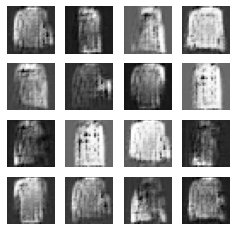

Time for epoch 1 is 365.9274265766144 sec


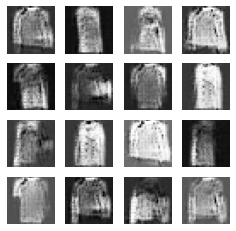

Time for epoch 2 is 408.01549100875854 sec


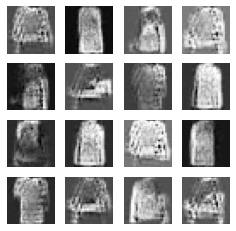

Time for epoch 3 is 409.83094573020935 sec


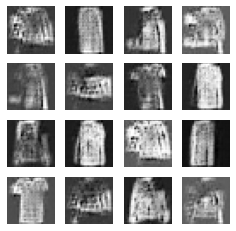

Time for epoch 4 is 410.56946301460266 sec


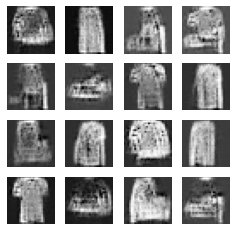

Time for epoch 5 is 358.86372804641724 sec


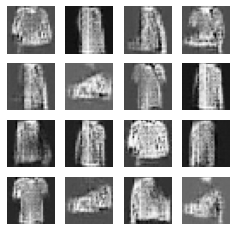

Time for epoch 6 is 369.5811800956726 sec


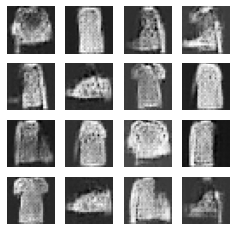

Time for epoch 7 is 318.5372471809387 sec


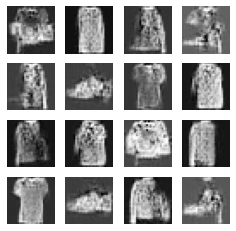

Time for epoch 8 is 376.1987283229828 sec


KeyboardInterrupt: 

In [242]:
train(train_set, epochs)